#### Rasa Rahnema, ryrahnem@uwaterloo.ca
# Adverserial-Free Methods for Inpainting

It is well known that as a general rule, l1/l2 losses produce blurry inpaints and adverserial networks produce more clear results, however those require you to find the solution to a min-max problem (nash equilbrium) of the network which is a very difficult problem and prone to overfitting. We will avoid nash equilibriums and instead explore possibilities for clear inpaints which only involve the optimization of a single network. With available resources and time constraints , we hope to create a simple yet robust inpainting model which can inpaint beyond the dataset it was trained on and be trained feasibly using a standard GPU.

As opposed to l1/l2 losses, we can use a smarter loss function. Instead of the loss function forcing the generator to produce exactly what was blotted out, we will use a pretrained classification model in order to extract out the necessary features from both images. It is from those higher level features that we will perform l1 loss on.

Since we plan on leaving the VGG16 model weights as is, this allows us to avoid searching for a nash equilibrium and to only focus on minimizing the loss for the generator. We will also build a baseline model trained on the l2 loss over the images themselves in order to compare the quality of their inpaints.



### External Libraries
[1] Code used for loss function https://github.com/MathiasGruber/PConv-Keras/blob/master/libs/pconv_model.py

Credits go to Mathias Gruber

### Papers Cited
[2] Tim S, Ian G, et al. (2016). Improved Techniques for Training GANs. https://arxiv.org/pdf/1606.03498.pdf

[3] Guilin L, Fitsum A, et al. (2018). Image Impainting for Irregular Holes Using Partial Convolutions. In: European Conference on Computer Vision (ECCV). https://arxiv.org/pdf/1804.07723.pdf

### Dataset
Tiny Imagenet: https://huggingface.co/datasets/zh-plus/tiny-imagenet/blob/main/data/train-00000-of-00001-1359597a978bc4fa.parquet

In [1]:
from random import randint
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from io import BytesIO
import keras.backend as K
import gc

## Masking

For training, we will use a very simple mask with a randomly placed 15x15 square on the image. This same mask will then be used for all our testing.

In [2]:
class MaskGenerator():
    def __init__(self, height, width):
        self.height = height
        self.width = width

    # Generate a fixed square mask at a random point within the image
    def generate_square_mask(self):
        mask = np.full((self.height, self.width, 3), True)
        mask_height = 15
        mask_width = 15
        x = np.random.randint(0, self.height - mask_height)
        y = np.random.randint(0, self.width - mask_width)
        mask[x:x+mask_height, y:y+mask_width, :] = False
        return tf.convert_to_tensor(mask)

def GenerateMasks(nmasks):
    masks = [0]*nmasks
    for i in range(nmasks):
        masks[i] = maskGenerator.generate_square_mask()
    return tf.convert_to_tensor(masks)
maskGenerator = MaskGenerator(64,64)

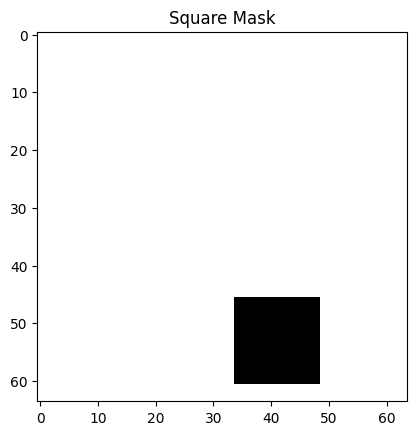

In [ ]:
plt.imshow(np.array(maskGenerator.generate_square_mask(), dtype='int32')*255)
plt.title('Square Mask')
plt.show()

## Data Loading

In order to make the training process more feasible, instead of training on the standard imagenet images, we use the tiny imagenet dataset consisting of 100000 64x64 rgb images over 100 classes. This dataset is then shuffled and can be stored entirely in memory.

In [3]:
data = pd.read_parquet("/content/drive/MyDrive/Colab_Notebooks/imagenet.parquet")
ims = [0]*100000
for i in range(100000):
    image = Image.open(BytesIO(data.iloc[i,0]['bytes']))
    if (image.layers < 3):
        image = image.convert("RGB")
    ims[i] = image
ims = np.array(ims)
np.random.shuffle(ims)
ims = tf.convert_to_tensor(ims)

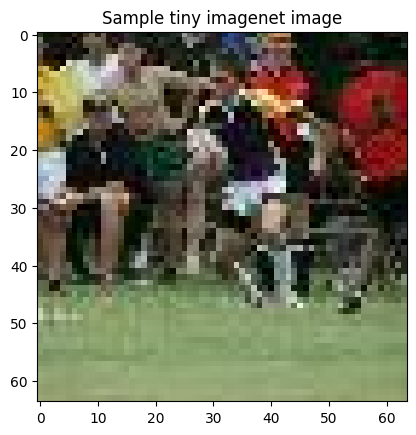

In [ ]:
plt.imshow(ims[0])
plt.title("Sample tiny imagenet image")
plt.show()

## Model Architecture

A standard U-net architecture is used as the inpainter without any pretrained weights. The U-net is a simple combination of convolution, max pooling, upsampling, activation, batchnorm, and concatenation layers. This architecture receives the masked 64x64 image and outputs another inpainted 64x64 image, but considering only the inpainted sections are required, the output will be overlayed on top of the original image for prediction.

The pretrained classification model we choose to use is the VGG16 model with imagenet weights. These weights will not be modified at any point in the training.


In [4]:
from keras.models import Model
from keras.layers import (Input, Conv2D, UpSampling2D, BatchNormalization, Activation, Concatenate,
                          MaxPooling2D, Resizing, Layer, Multiply, Dense, Flatten, LayerNormalization, Lambda)

def build_unet(complexLoss, nrows=64, ncols=64):
    def encoder_layer(img_in, filters, kernel_size):
        conv = Conv2D(filters, (kernel_size, kernel_size), padding='same')(img_in)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D((2, 2), padding='same')(conv)
        return conv
    def decoder_layer(img_in, concat, filters, kernel_size):
        conv = UpSampling2D(size=(2,2))(img_in)
        conv = Concatenate(axis=3)([conv, concat])
        conv = Conv2D(filters, (kernel_size, kernel_size), padding='same')(conv)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
        return conv
    input = Input((nrows, ncols, 3))
    mask = Input((nrows, ncols, 3))
    input2 = (1/255)*Multiply()([input, mask])

    # Normalization using the given mean and std of the imagenet dataset,
    # we're not using the imagenet dataset but values are similar enough
    input3 = Lambda(lambda x: (x-[0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225])(input2)
    conv1 = encoder_layer(input3, 32, 7)
    conv2 = encoder_layer(conv1, 64, 5)
    conv3 = encoder_layer(conv2, 128, 3)
    conv4 = encoder_layer(conv3, 256, 3)
    conv5 = decoder_layer(conv4, conv3, 256, 3)
    conv6 = decoder_layer(conv5, conv2, 128, 3)
    conv7 = decoder_layer(conv6, conv1, 64, 3)
    conv8 = decoder_layer(conv7, input3, 32, 3)
    output = Conv2D(3, 1, activation = 'sigmoid')(conv8)
    if not complexLoss:
        output2 = input2 + Multiply()([output, 1-mask])
        model = Model(inputs=[input, mask], outputs=255*output2)
    else:
        # Concatenate mask with output as loophole to get the mask into the loss function
        model = Model(inputs=[input, mask], outputs=Concatenate(axis=3)([output, mask]))
    return model

# Full VGG model only accepts 224x224 images, in order for it to work on our dataset
# images must be rescaled to 224x224 first.
def build_vgg():
    vgg16_model = keras.applications.VGG16(weights="imagenet")
    model = keras.Sequential()
    model.add(Input((64, 64, 3)))
    model.add(Resizing(224,224))
    for layer in vgg16_model.layers[1:-1]:
        layer.trainable = False
        model.add(layer)
    return model

# VGG model where the first 3 pooling layers are taken as output, as their
# features are more meaningful. Layers prior to flattening are size agnostic
# and rescaling is unnecessary.
def build_complex_vgg():
    vgg16_model = keras.applications.VGG16(weights="imagenet", include_top=False)
    model = tf.keras.models.Model(
            inputs=[vgg16_model.input],
            outputs=[vgg16_model.get_layer('block1_pool').output,
                    vgg16_model.get_layer('block2_pool').output,
                    vgg16_model.get_layer('block3_pool').output])
    return model

class FeatureLoss(keras.losses.MeanSquaredError):
    def call(self, y_true, y_pred):
        y_pred = discriminator(y_pred)
        y_true = discriminator(y_true)
        return super().call(y_true, y_pred)

discriminator = build_vgg()

553467096/553467096 [==============================] - 14s 0us/step


Code referenced from [1], details discussed below.

In [5]:
def l1(y_true, y_pred):
    if K.ndim(y_true) == 4:
        return K.mean(K.abs(y_pred - y_true), axis=[1,2,3])
    elif K.ndim(y_true) == 3:
        return K.mean(K.abs(y_pred - y_true), axis=[1,2])
    else:
        raise NotImplementedError("Calculating L1 loss on 1D tensors? should not occur for this network")

def loss_hole(mask, y_true, y_pred):
    """Pixel L1 loss within the hole / mask"""
    return l1((1-mask) * y_true, (1-mask) * y_pred)

def loss_valid(mask, y_true, y_pred):
    """Pixel L1 loss outside the hole / mask"""
    return l1(mask * y_true, mask * y_pred)

def loss_perceptual(vgg_out, vgg_gt, vgg_comp):
    """Perceptual loss based on VGG16, see. eq. 3 in paper [3]"""
    loss = 0
    for o, c, g in zip(vgg_out, vgg_comp, vgg_gt):
        loss += l1(o, g) + l1(c, g)
    return loss

def loss_style(output, vgg_gt):
    """Style loss based on output/computation, used for both eq. 4 & 5 in paper [3]"""
    loss = 0
    for o, g in zip(output, vgg_gt):
        loss += l1(gram_matrix(o), gram_matrix(g))
    return loss

kernel = K.ones(shape=(3, 3, 3, 3))
def loss_tv(mask, y_comp):
    """Total variation loss, used for smoothing the hole region, see. eq. 6 [3]"""

    # Create dilated hole region using a 3x3 kernel of all 1s.
    dilated_mask = K.conv2d(1-mask, kernel, data_format='channels_last', padding='same')

    # Cast values to be [0., 1.], and compute dilated hole region of y_comp
    dilated_mask = K.cast(K.greater(dilated_mask, 0), 'float32')
    P = dilated_mask * y_comp

    # Calculate total variation loss
    a = l1(P[:,1:,:,:], P[:,:-1,:,:])
    b = l1(P[:,:,1:,:], P[:,:,:-1,:])
    return a+b

def gram_matrix(x):
    """Calculate gram matrix used in style loss"""

    # Assertions on input
    assert K.ndim(x) == 4, 'Input tensor should be a 4d (B, H, W, C) tensor'
    assert K.image_data_format() == 'channels_last', "Please use channels-last format"

    # Permute channels and get resulting shape
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    shape = K.shape(x)
    B, C, H, W = shape[0], shape[1], shape[2], shape[3]

    # Reshape x and do batch dot product
    features = K.reshape(x, K.stack([B, C, H*W]))
    gram = K.batch_dot(features, features, axes=2)

    # Normalize with channels, height and width
    gram = gram /  K.cast(C * H * W, x.dtype)

    return gram

In [6]:
def ComplexFeatureLoss(y_true, y_pred):
    # Compute predicted image with non-hole pixels set to ground truth

    mask = y_pred[:,:,:,3:]
    y_pred = y_pred[:,:,:,:3]
    y_true = (1/255) * tf.cast(y_true, tf.float32)
    y_comp = mask * y_true + (1-mask) * y_pred

    # Compute the vgg features.
    vgg_out = discriminator(y_pred)
    vgg_gt = discriminator(y_true)
    vgg_comp = discriminator(y_comp)

    # Compute loss components
    l1 = loss_valid(mask, y_true, y_pred)
    l2 = loss_hole(mask, y_true, y_pred)
    l3 = loss_perceptual(vgg_out, vgg_gt, vgg_comp)
    l4 = loss_style(vgg_out, vgg_gt)
    l5 = loss_style(vgg_comp, vgg_gt)
    l6 = loss_tv(mask, y_comp)

    # Return loss function
    return l1 + 6*l2 + 0.05*l3 + 120*(l4+l5) + 0.1*l6

## Model Training

We train 3 different models, all with the same architecture but with different loss functions. The 3 different loss functions are as follows:

**L2 loss:** As our baseline, we take the mean squared error of the outputted image minus the true image over each pixel and channel. We expect this to produce blurry results.

**Feature Loss:** We take both the outputted image and true image and feed it into the full VGG model minus the final softmax layer. This gives us a 4096 long feature tensor for which, the mean squared error is then calculated. In the paper [2], using features from the image as an objective will prevent the generator from overfitting on the current discriminator. Since our discriminator is already pretrained this allows us to only focus on the generator. Using features from previous layers should also work.

**Complex Feature Loss:** Instead of choosing only features from the dense layer, this loss function combines features from many layers at once as well as including various penalties with specific weights. This loss function was initially proposed in [3]. This loss function consists of 6 different components which can be understood to an extent intuitively.

**1:** The l1 loss for the predicted image inside of the masked region.

**2:** The l1 loss for the predicted image outside of the masked region.

**3:** The l1 loss between the output of the first 3 pooling layers of both the predicted image and true image, and the overlayed predicted image and true image.

**4/5.** The l1 loss between the corresponding gram matrices of the first 3 pooling layers of the images.

**6.** Smoothing penalty for inpaints within the masked regions.

The proposed weights for each of these components in the paper are 1, 6, 0.05, 120, 0.1 and these are the weights we will be using [3]. Considering the size of the VGG model, it takes a significant amount of time to completely train the latter 2 models and so we have to use limited epochs and a high learning rate.

In [ ]:
# l2 loss model, takes ~20mins to train
# Code output isn't shown because they were trained using multiple sessions at a time
generator = build_unet(complexLoss = False)
generator.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss="mse")
epochs = 20
for _ in range(epochs):
    masks = GenerateMasks(100000)
    generator.fit([ims[:90000], masks[:90000]], ims[:90000], validation_data = ([ims[90000:], masks[90000:]], ims[90000:]),
                  epochs=1, batch_size=64)
    K.clear_session()
    gc.collect()
generator.save_weights('/content/drive/MyDrive/Colab_Notebooks/model1.h5')

In [ ]:
# Feature loss model, takes ~4hrs to train
generator = build_unet(complexLoss = False)
generator.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss=FeatureLoss)
epochs = 10
for _ in range(epochs):
    masks = GenerateMasks(100000)
    generator.fit([ims[:90000], masks[:90000]], ims[:90000], validation_data = ([ims[90000:], masks[90000:]], ims[90000:]),
                  epochs=1, batch_size=64)
    K.clear_session()
    gc.collect()
generator.save_weights('/content/drive/MyDrive/Colab_Notebooks/model2.h5')

In [7]:
# Complex feature loss model, takes ~2hrs to train
discriminator = build_complex_vgg()
generator = build_unet(complexLoss = True)
generator.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss=ComplexFeatureLoss)
epochs = 10
for _ in range(epochs):
    masks = GenerateMasks(100000)
    generator.fit([ims[:90000], masks[:90000]], ims[:90000], validation_data = ([ims[90000:], masks[90000:]], ims[90000:]),
                  epochs=1, batch_size=64)
    K.clear_session()
    gc.collect()
generator.save_weights('/content/drive/MyDrive/Colab_Notebooks/model3.h5')

1407/1407 [==============================] - 220s 155ms/step - loss: 4.8261 - val_loss: 4.6801


## Model Evaluation
Now we test all 3 models on some images from the validation set using the same masks.

In [8]:
generator1 = build_unet(complexLoss = False)
generator1.load_weights('/content/drive/MyDrive/Colab_Notebooks/model1.h5')
generator2 = build_unet(complexLoss = False)
generator2.load_weights('/content/drive/MyDrive/Colab_Notebooks/model2.h5')
generator3 = build_unet(complexLoss = True)
generator3.load_weights('/content/drive/MyDrive/Colab_Notebooks/model3.h5')

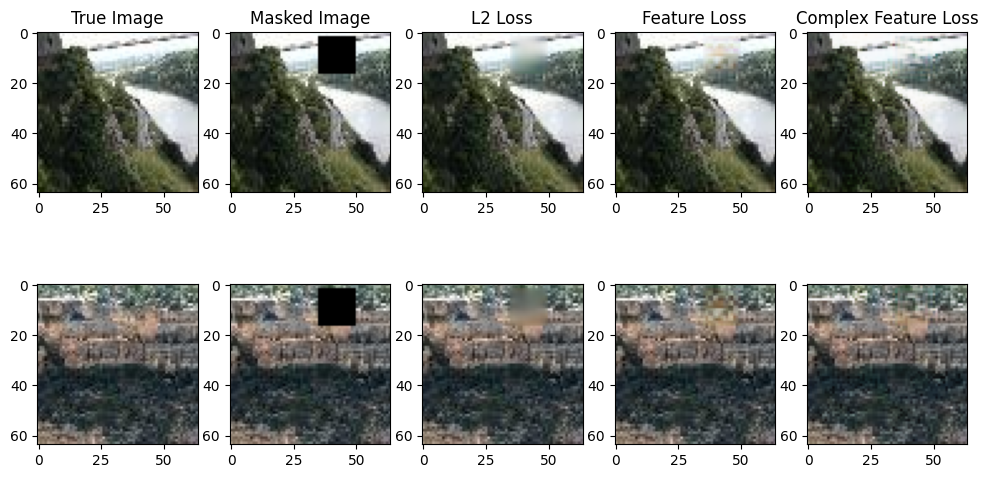

In [15]:
f, axarr = plt.subplots(2,5,figsize=(12, 6))
mask = maskGenerator.generate_square_mask()
ind1=90013
ind2=90014
axarr[0,0].imshow(ims[ind1])
axarr[0,1].imshow(ims[ind1] * np.array(mask, dtype='int32'))
axarr[0,2].imshow(generator1([np.array([ims[ind1]]), np.array([mask])]).numpy()[0]/255)
axarr[0,3].imshow(generator2([np.array([ims[ind1]]), np.array([mask])]).numpy()[0]/255)
axarr[0,4].imshow(generator3([np.array([ims[ind1]]), np.array([mask])]).numpy()[0,:,:,:3])
axarr[1,0].imshow(ims[ind2])
axarr[1,1].imshow(ims[ind2] * np.array(mask, dtype='int32'))
axarr[1,2].imshow(generator1([np.array([ims[ind2]]), np.array([mask])]).numpy()[0]/255)
axarr[1,3].imshow(generator2([np.array([ims[ind2]]), np.array([mask])]).numpy()[0]/255)
axarr[1,4].imshow(generator3([np.array([ims[ind2]]), np.array([mask])]).numpy()[0,:,:,:3])
axarr[0,0].set_title('True Image')
axarr[0,1].set_title('Masked Image')
axarr[0,2].set_title('L2 Loss')
axarr[0,3].set_title('Feature Loss')
axarr[0,4].set_title('Complex Feature Loss')
plt.show()

For testing true out of sample images, here I use 2 pictures I took myself.

In [10]:
img1 = Image.open("/content/drive/MyDrive/Colab_Notebooks/1713916616727.jpg")
img2 = Image.open("/content/drive/MyDrive/Colab_Notebooks/1713916616741.jpg")
img1 = np.array(img1.resize((64,64)))
img2 = np.array(img2.resize((64,64)))

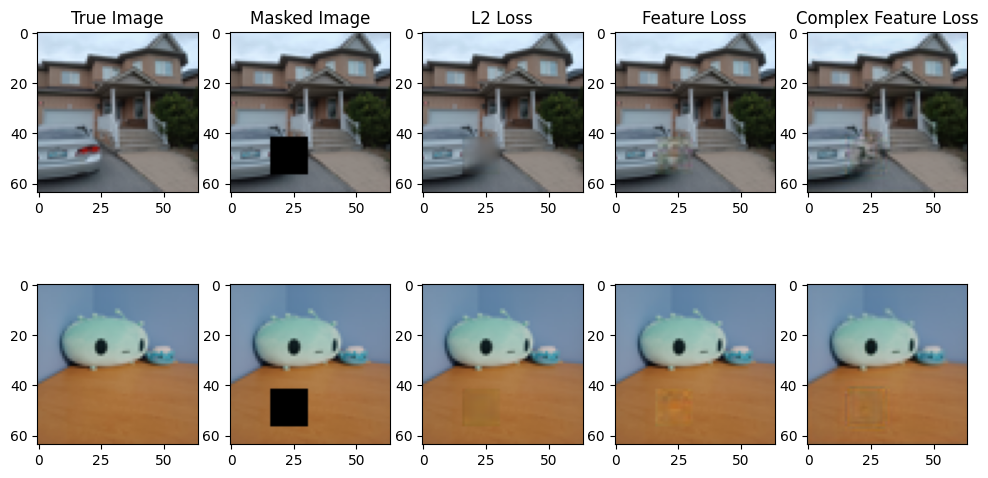

In [16]:
mask = maskGenerator.generate_square_mask()
f, axarr = plt.subplots(2,5,figsize=(12, 6))
axarr[0,0].imshow(img1)
axarr[0,1].imshow(img1 * np.array(mask, dtype='int32'))
axarr[0,2].imshow(generator1([np.array([img1]), np.array([mask])]).numpy()[0]/255)
axarr[0,3].imshow(generator2([np.array([img1]), np.array([mask])]).numpy()[0]/255)
axarr[0,4].imshow(generator3([np.array([img1]), np.array([mask])]).numpy()[0,:,:,:3])
axarr[1,0].imshow(img2)
axarr[1,1].imshow(img2 * np.array(mask, dtype='int32'))
axarr[1,2].imshow(generator1([np.array([img2]), np.array([mask])]).numpy()[0]/255)
axarr[1,3].imshow(generator2([np.array([img2]), np.array([mask])]).numpy()[0]/255)
axarr[1,4].imshow(generator3([np.array([img2]), np.array([mask])]).numpy()[0,:,:,:3])
axarr[0,0].set_title('True Image')
axarr[0,1].set_title('Masked Image')
axarr[0,2].set_title('L2 Loss')
axarr[0,3].set_title('Feature Loss')
axarr[0,4].set_title('Complex Feature Loss')
plt.show()

## Conclusion

As it turns out, training inpainting models is very computationally intensive, even limiting ourselves to 64x64 images we still run into significant constraints and we're unable to train the models fully. Regardless, we can still get a gauge of their performance.

Our baseline l2 loss performs as we expected, it has decent accuracy but is incredibly blurry. Theoretically this makes sense as inpainting is not a problem where loss can be minimized, multiple different inpaints may make sense but the model tries to average them all out, resulting in the blurriness.

Our feature loss model is less blurry but it's not really as accurate. Since the features are only taken during the last layer of the model, those features likely describe the image on a macroscale considering that this is a classification model. There is proven success with loss over features though so lack of training may play a huge role.

The final model shows clear performance improvements over both models, features taken through the max pooling layers solves the issue of only having macrofeatures to optimize over. There isn't an adverserial network for comparison but many of these images I can't tell are fake. At the very least this shows that results better than l2 loss can be achieved without resorting to adverserial networks.

In [ ]:
print("hi")